# Vizualisation of temporal consistency of predictions

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as mpatches
import os
import rasterio
from rasterio.windows import Window
import numpy as np

proj_dir = os.path.dirname(os.getcwd())
exp_dir = os.path.join(proj_dir, 'output')

In [2]:
alpha = 0.8

yellow = np.array([255, 195, 18, 255 * alpha]) / 255
gray = np.array([100, 100, 100, 255 * alpha]) / 255
orange = np.array([238, 90, 36, 255 * alpha]) / 255
light_orange = np.array([247, 159, 31, 255 * alpha]) / 255
blue = np.array([6, 82, 221, 255 * alpha]) / 255

colormap_pred = np.zeros((256, 4))
colormap_pred[1] = yellow
colormap_pred[-1] = gray

colormap_0_1 = np.zeros((256, 4))
colormap_0_1[1] = blue
colormap_0_1[-1] = gray

colormap_1_0 = np.zeros((256, 4))
colormap_1_0[1] = light_orange
colormap_1_0[-1] = gray

patch_size = 250
fig_scale = 5

In [ ]:
exp_name_list = ['Unet_SI2020_100cm_grayaugment_rs0',
                'NIrregGRU7df_bwrd_freeze0_lrfe1em06_lrtemp0_0001_tlossCE_asymgraddot_ltemp1_0_1_0_rs1']
                    
exp_short_name_list = ['baseline',
                       'proposed']
set = 'test'
epoch_list = ['19', '39']

input_dir = os.path.join(os.path.dirname(os.path.dirname(proj_dir)), 'Data', 'SwissImage')

dir_list = [os.path.join(exp_dir, exp_name, 'inference', 'epoch_{}'.format(e), set) for exp_name, e in zip(exp_name_list, epoch_list)]

In [4]:
def hide_axis(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['bottom'].set_color((0.0,)*4)
    ax.spines['top'].set_color((0.0,)*4) 
    ax.spines['right'].set_color((0.0,)*4)
    ax.spines['left'].set_color((0.0,)*4)

In [15]:
def plot_diff_results(tk,               
                 year,
                 n_previous=None,
                 n_next=None,
                 x_start=0,
                 y_start=0,
                 year_list=None,
                 fn_suffix=None):
    
    for i in range(len(exp_name_list)):
        
        if isinstance(year, list):    
            pred_im_list = []
            year_list = year
            
            for y in year_list:
                if y is None:
                    pred_im_list.append(None)
                else:
                    im_next_fn = os.path.join(dir_list[i], 'predictions_{}_{}.tif'.format(y, tk))
                    if os.path.isfile(im_next_fn):
                        with rasterio.open(im_next_fn, 'r') as f_next:
                            im = f_next.read(1, window=Window(x_start, y_start, patch_size, patch_size))
                            pred_im_list.append(im)
            
            pred_im_list = [v if v is not None else np.empty_like(im) for v in pred_im_list]                
           
                    
        else:
            # read prediction
            im_fn = os.path.join(dir_list[i], 'predictions_{}_{}.tif'.format(year, tk))
            with rasterio.open(im_fn, 'r') as f:
                im = f.read(1, window=Window(x_start, y_start, patch_size, patch_size))
            pred_im_list = [im]
            year_list = [year]
            # look for next prediction(s)
            count = 0
            year_next = year + 1
            while count < n_next and year_next <= 2020:
                im_next_fn = os.path.join(dir_list[i], 'predictions_{}_{}.tif'.format(year_next, tk))
                if os.path.isfile(im_next_fn):
                    with rasterio.open(im_next_fn, 'r') as f_next:
                        pred_im_list.append(f_next.read(1, window=Window(x_start, y_start, patch_size, patch_size)))
                        year_list.append(year_next) 
                    count += 1
                year_next += 1
        
            # look for previous prediction(s)
            count = 0
            year_previous = year - 1
            while count < n_previous and year_previous >= 1946:
                im_previous_fn = os.path.join(dir_list[i], 'predictions_{}_{}.tif'.format(year_previous, tk))
                if os.path.isfile(im_previous_fn):
                    with rasterio.open(im_previous_fn, 'r') as f_previous:
                        pred_im_list = [f_previous.read(1, window=Window(x_start, y_start, patch_size, patch_size))] + pred_im_list
                        year_list = [year_previous] + year_list
                        count += 1
                year_previous -= 1
                
        
        
        if i == 0:
            # read input images
            input_im_list = []
            for y in year_list:
                if y is None:
                    input_im_list.append(None)
                else:
                    input_fn = os.path.join(input_dir, str(y), '100cm', 'DOP100_LV95_{}_{}.tif'.format(tk, y))
                    with rasterio.open(input_fn, 'r') as f_input:
                        input_im_list.append(np.moveaxis(f_input.read(window=Window(x_start, y_start, patch_size, patch_size)),
                                                         (0, 1, 2), 
                                                         (2, 0, 1)))
            nrows = 1 + len(exp_name_list)
            n_years = len(year_list)
            width_ratios = [0.1 if y is None else 1 for y in year_list]
            _, ax = plt.subplots(nrows=nrows, 
                                   ncols=n_years, 
                                   figsize=(fig_scale*np.sum(np.array(width_ratios)), fig_scale*nrows),
                                   gridspec_kw={'width_ratios': width_ratios})
            ax[i, 0].set_ylabel('aerial image', rotation=90, size=52)
            current_col = 0
            for j, (input_im, pred_im, y) in enumerate(zip(input_im_list, pred_im_list, year_list)):
                hide_axis(ax[i, current_col])
                if j == len(year_list) - 1:
                    scalebar = ScaleBar(1.0,
                                        length_fraction=0.5,
                                        font_properties={"size": 46})
                    ax[i, current_col].add_artist(scalebar)
                if y is None:
                    if year_list[j-1] is not None:
                        ax[i, current_col].text(0.5, 0.5, '...', 
                                                fontsize=38, 
                                                ha='center')
                        current_col += 1
                else:
                    cmap='gray' if input_im.shape[-1] == 1 else None
                    ax[i, current_col].imshow(input_im, cmap=cmap)
                    ax[i, current_col].set_title(str(y), size=52)
                    current_col += 1
                        
        # plot predictions
        ax[i+1, 0].set_ylabel(exp_short_name_list[i], rotation=90, size=52)
        current_col = len(year_list) - 1
        prev_im = None
        j = len(year_list) - 1
        for (input_im, pred_im, y) in zip(reversed(input_im_list), reversed(pred_im_list), reversed(year_list)):
            hide_axis(ax[i+1, current_col])
            if y is None:
                if year_list[j-1] is not None:
                    ax[i+1, current_col].text(0.5, 0.5, '...', 
                                              fontsize=52, 
                                              ha='center')
                    current_col -= 1
            else:
                
                
                if current_col == len(year_list) - 1:
                    # create a patch (proxy artist) for every color 
                    colors = [colormap_0_1[1], colormap_1_0[1]]
                    labels = ['gain', 'loss']
                    patches = [ mpatches.Patch(color=colors[k], label=labels[k]) for k in range(len(colors)) ]
                    # put those patched as legend-handles into the legend
                    ax[i+1, current_col].legend(handles=patches, 
                                                loc='upper right', 
                                                fontsize=46
                                                )
                    placeholder = np.full_like(input_im, fill_value=255)
                    ax[i+1, current_col].imshow(placeholder, alpha=1.0)
                else:
                    cmap='gray' if input_im.shape[-1] == 1 else None
                    ax[i+1, current_col].imshow(input_im, cmap=cmap, alpha=0.4)
                if (prev_im is not None):
                    pred_im_0_1 = (pred_im < prev_im).astype(int)
                    ax[i+1, current_col].imshow(colormap_0_1[pred_im_0_1])
                    pred_im_1_0 = (pred_im > prev_im).astype(int)
                    ax[i+1, current_col].imshow(colormap_1_0[pred_im_1_0])
                current_col -= 1
                prev_im = pred_im                                 
                    
            j -= 1
          
    plt.tight_layout()
    plt.savefig('loss_comparison_diff_{}.pdf'.format(tk if fn_suffix is None else fn_suffix))
    plt.show()

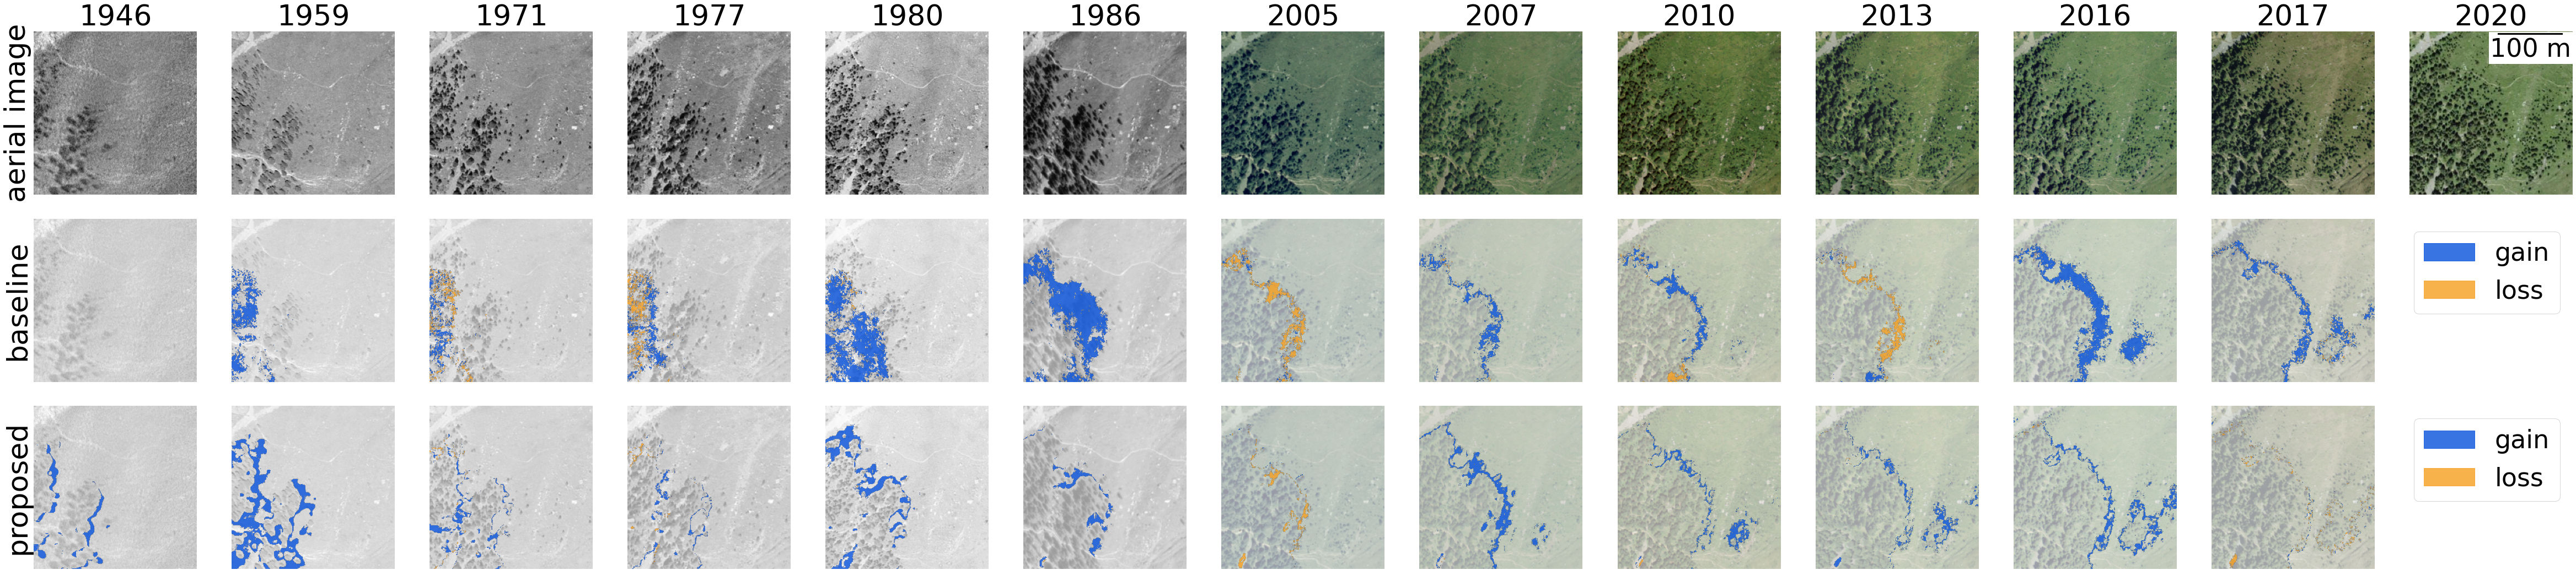

In [16]:
tk = '2614_1114'
year = 2005
n_previous = 10
n_next = 10

x_start = 450
y_start = 600

plot_diff_results(tk=tk,               
             year=year,               
             n_previous=n_previous,               
             n_next=n_next,               
             x_start=x_start,               
             y_start=y_start)